In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Loading Data
data = pd.read_csv("/content/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])


In [ ]:
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

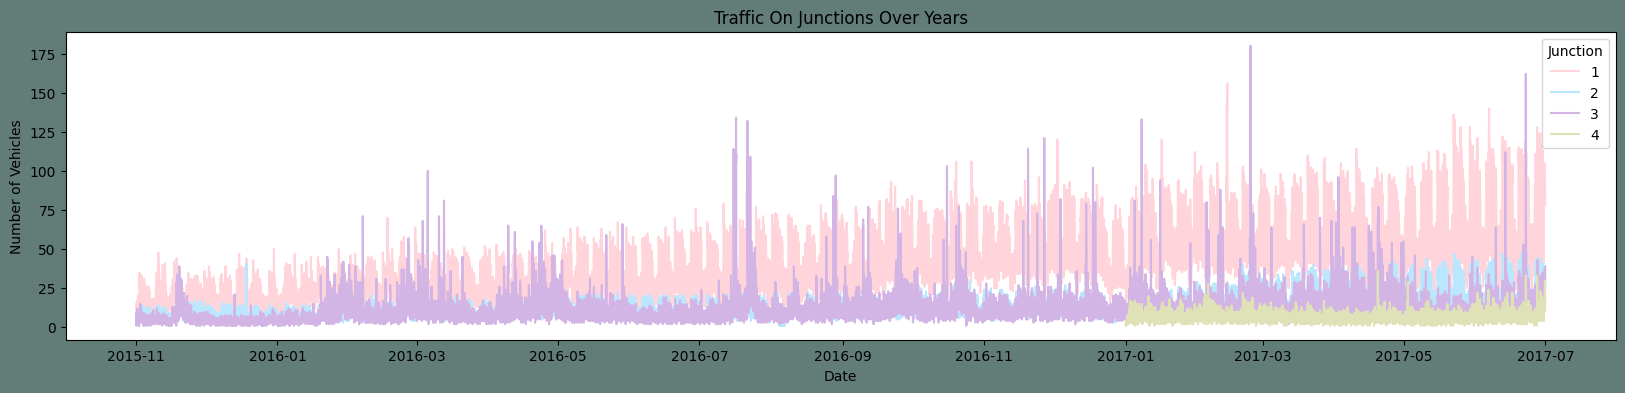

In [ ]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


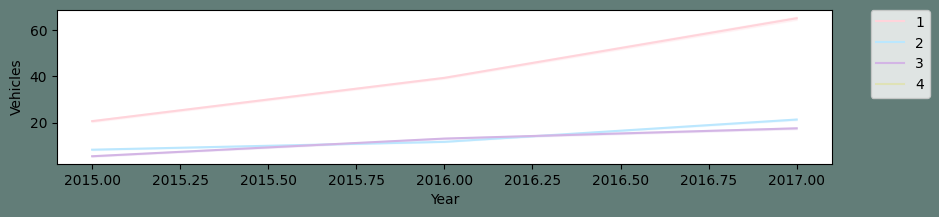

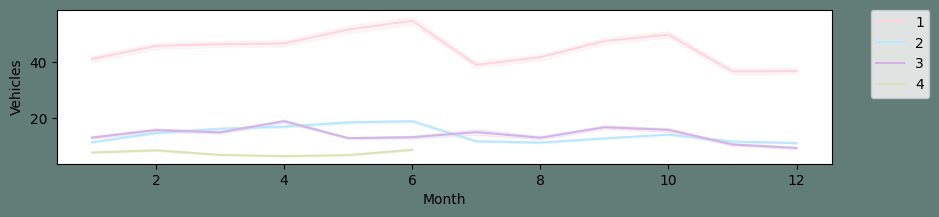

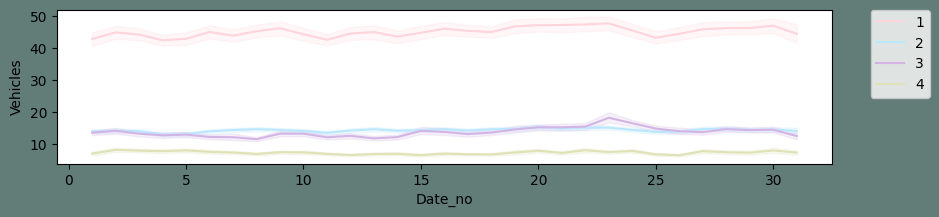

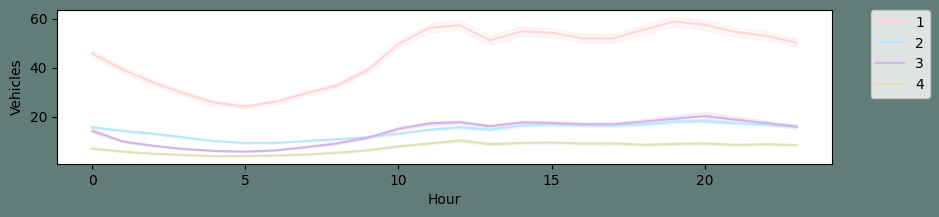

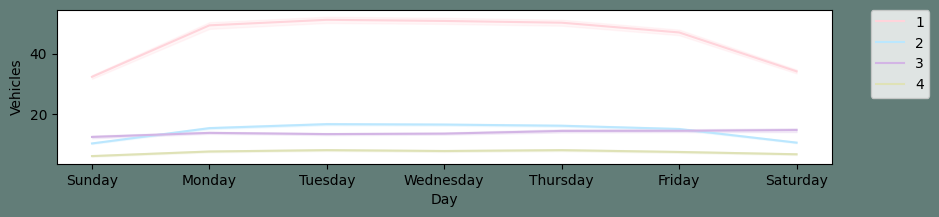

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

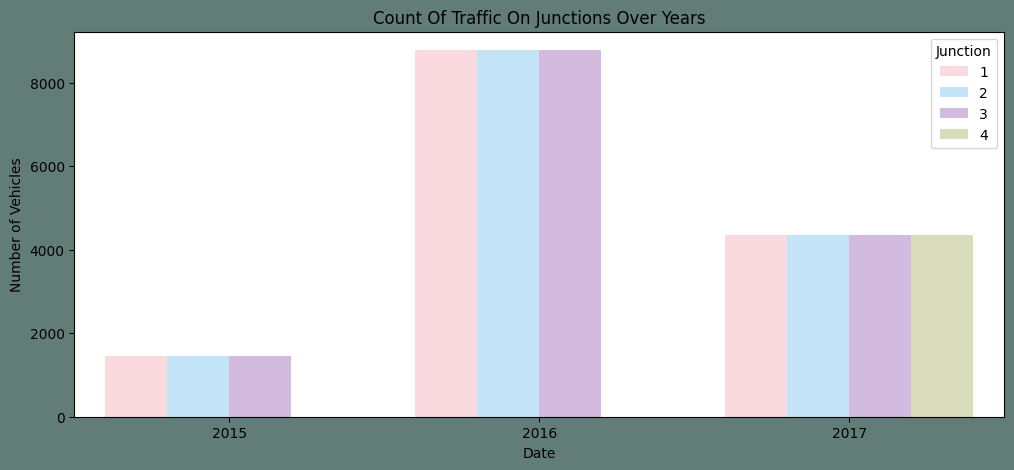

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

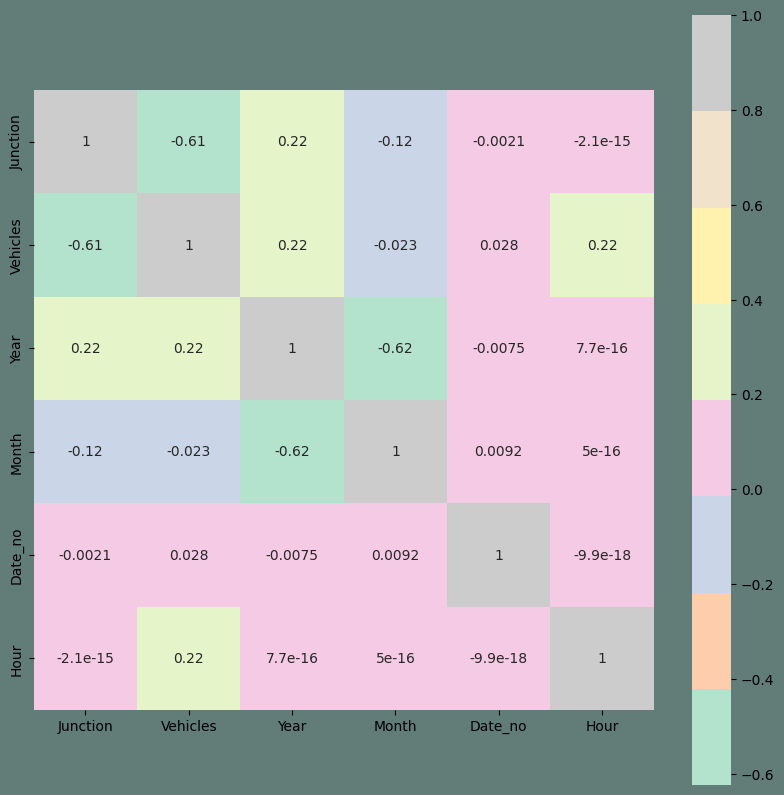

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

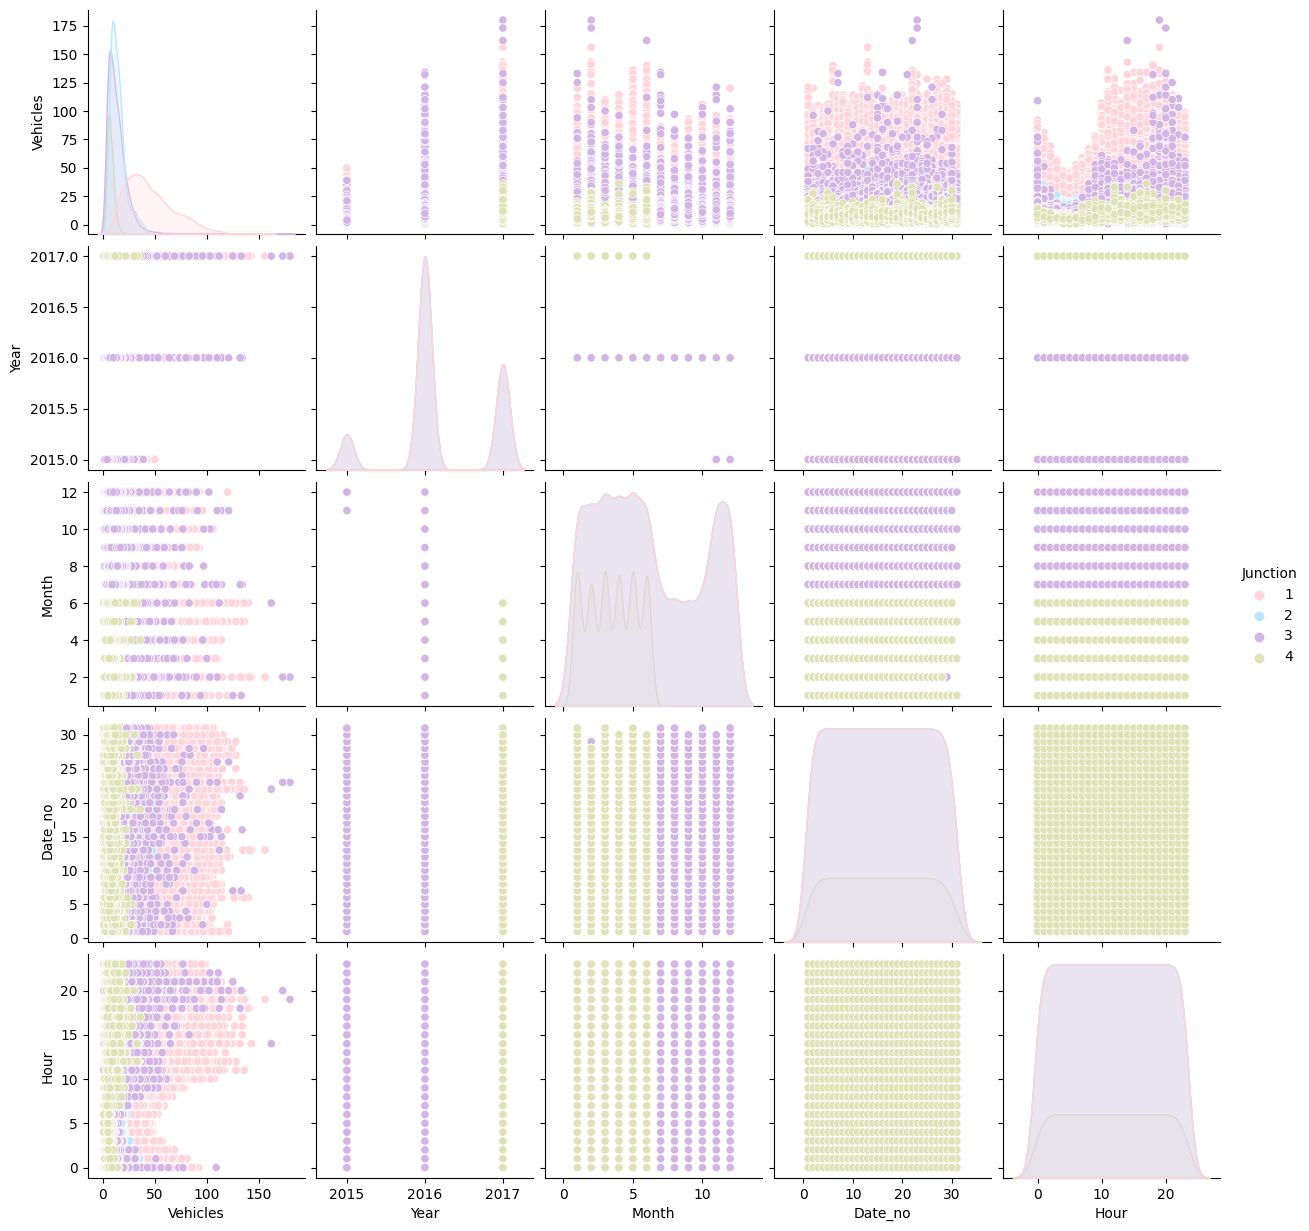

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [ ]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

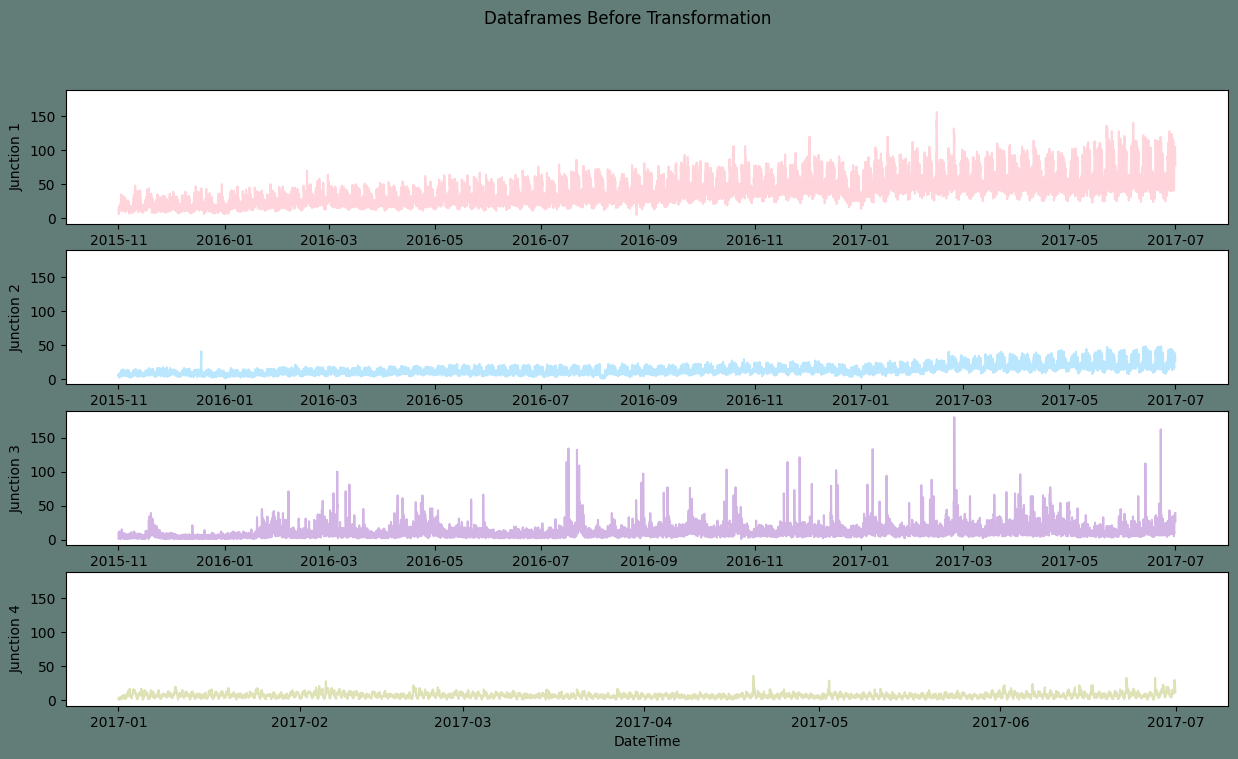

In [ ]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

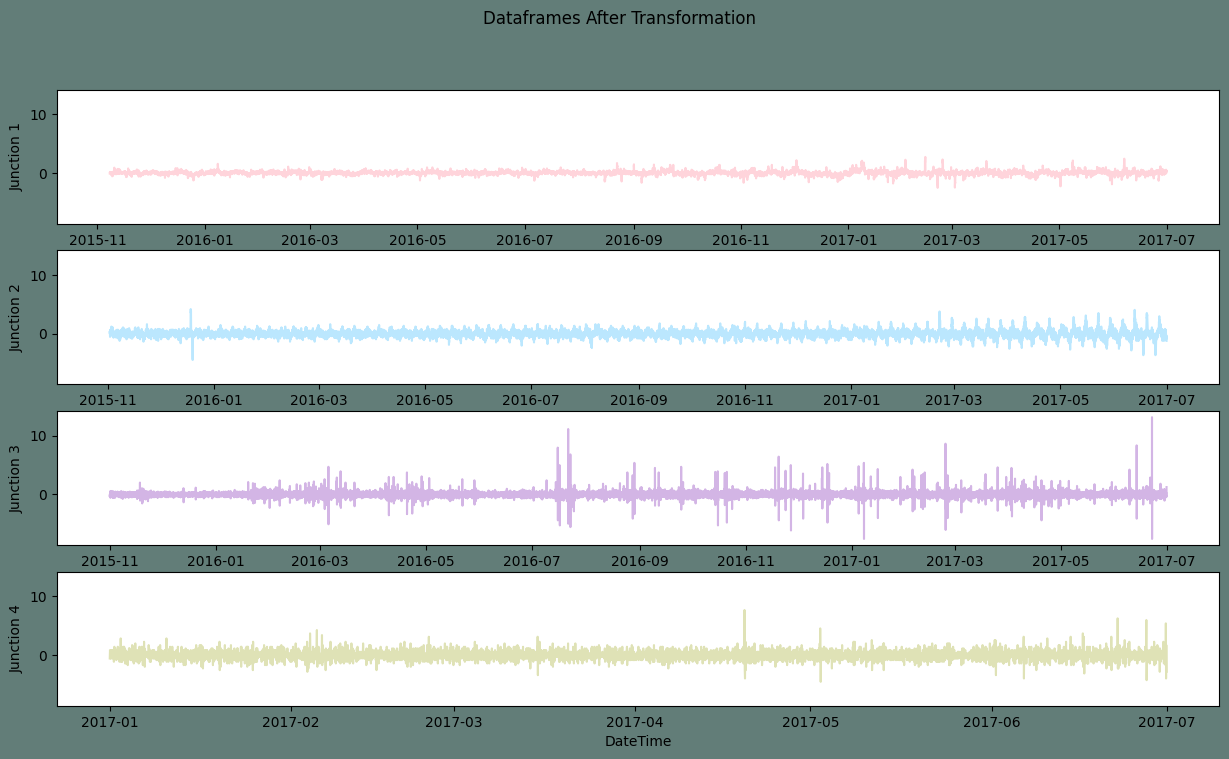

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415504
p-value: 4.798539876395756e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694011
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832504
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305238
p-value: 2.7787875325952613e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [ ]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    
    sgd=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.0820

87/87 [==============================] - 14s 16ms/step - loss: 0.0820
Epoch 2/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0663

87/87 [==============================] - 1s 13ms/step - loss: 0.0668
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.0641

87/87 [==============================] - 1s 13ms/step - loss: 0.0641
Epoch 4/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0633

87/87 [==============================] - 1s 15ms/step - loss: 0.0633
Epoch 5/50
86/87 [============================>.] - ETA: 0s - loss: 0.0618

87/87 [==============================] - 1s 13ms/step - loss: 0.0620
Epoch 6/50
87/87 [==============================] - ETA: 0s - loss: 0.0613

87/87 [==============================] - 1s 13ms/step - loss: 0.0613
Epoch 7/50
87/87 [==============================] - ETA: 0s - loss: 0.0594

87/87 [==============================] - 1s 12ms/step - loss: 0.0594
Epoch 8/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0592

87/87 [==============================] - 1s 13ms/step - loss: 0.0592
Epoch 9/50
87/87 [==============================] - ETA: 0s - loss: 0.0584

87/87 [==============================] - 1s 13ms/step - loss: 0.0584
Epoch 10/50
85/87 [============================>.] - ETA: 0s - loss: 0.0571

87/87 [==============================] - 1s 16ms/step - loss: 0.0573
Epoch 11/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0562

87/87 [==============================] - 1s 16ms/step - loss: 0.0566
Epoch 12/50
85/87 [============================>.] - ETA: 0s - loss: 0.0559

87/87 [==============================] - 1s 13ms/step - loss: 0.0562
Epoch 13/50
86/87 [============================>.] - ETA: 0s - loss: 0.0552

87/87 [==============================] - 1s 13ms/step - loss: 0.0552
Epoch 14/50
86/87 [============================>.] - ETA: 0s - loss: 0.0550

87/87 [==============================] - 1s 13ms/step - loss: 0.0550
Epoch 15/50
85/87 [============================>.] - ETA: 0s - loss: 0.0541

87/87 [==============================] - 1s 13ms/step - loss: 0.0538
Epoch 16/50
87/87 [==============================] - ETA: 0s - loss: 0.0540

87/87 [==============================] - 2s 18ms/step - loss: 0.0540
Epoch 17/50
87/87 [==============================] - ETA: 0s - loss: 0.0529

87/87 [==============================] - 2s 22ms/step - loss: 0.0529
Epoch 18/50
87/87 [==============================] - ETA: 0s - loss: 0.0528

87/87 [==============================] - 1s 15ms/step - loss: 0.0528
Epoch 19/50
86/87 [============================>.] - ETA: 0s - loss: 0.0523

87/87 [==============================] - 2s 17ms/step - loss: 0.0522
Epoch 20/50
87/87 [==============================] - ETA: 0s - loss: 0.0520

87/87 [==============================] - 2s 18ms/step - loss: 0.0520
Epoch 21/50
85/87 [============================>.] - ETA: 0s - loss: 0.0514

87/87 [==============================] - 1s 14ms/step - loss: 0.0515
Epoch 22/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0518

87/87 [==============================] - 1s 14ms/step - loss: 0.0516
Epoch 23/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0515

87/87 [==============================] - 1s 14ms/step - loss: 0.0513
Epoch 24/50
87/87 [==============================] - ETA: 0s - loss: 0.0517

87/87 [==============================] - 1s 14ms/step - loss: 0.0517
Epoch 25/50
87/87 [==============================] - ETA: 0s - loss: 0.0506

87/87 [==============================] - 1s 14ms/step - loss: 0.0506
Epoch 26/50
87/87 [==============================] - ETA: 0s - loss: 0.0503

87/87 [==============================] - 1s 15ms/step - loss: 0.0503
Epoch 27/50
87/87 [==============================] - ETA: 0s - loss: 0.0501

87/87 [==============================] - 1s 14ms/step - loss: 0.0501
Epoch 28/50
87/87 [==============================] - ETA: 0s - loss: 0.0501

87/87 [==============================] - 1s 15ms/step - loss: 0.0501
Epoch 29/50
85/87 [============================>.] - ETA: 0s - loss: 0.0501

87/87 [==============================] - 2s 19ms/step - loss: 0.0500
Epoch 30/50
87/87 [==============================] - ETA: 0s - loss: 0.0497

87/87 [==============================] - 1s 16ms/step - loss: 0.0497
Epoch 31/50
85/87 [============================>.] - ETA: 0s - loss: 0.0498

87/87 [==============================] - 1s 13ms/step - loss: 0.0496
Epoch 32/50
86/87 [============================>.] - ETA: 0s - loss: 0.0486

87/87 [==============================] - 1s 13ms/step - loss: 0.0487
Epoch 33/50
83/87 [===========================>..] - ETA: 0s - loss: 0.0493

87/87 [==============================] - 1s 13ms/step - loss: 0.0490
Epoch 34/50
86/87 [============================>.] - ETA: 0s - loss: 0.0485

87/87 [==============================] - 1s 13ms/step - loss: 0.0489
Epoch 35/50
86/87 [============================>.] - ETA: 0s - loss: 0.0487

87/87 [==============================] - 1s 13ms/step - loss: 0.0487
Epoch 36/50
85/87 [============================>.] - ETA: 0s - loss: 0.0491

87/87 [==============================] - 1s 13ms/step - loss: 0.0490
Epoch 37/50
86/87 [============================>.] - ETA: 0s - loss: 0.0491

87/87 [==============================] - 1s 13ms/step - loss: 0.0491
Epoch 38/50
86/87 [============================>.] - ETA: 0s - loss: 0.0487

87/87 [==============================] - 1s 13ms/step - loss: 0.0486
Epoch 39/50
86/87 [============================>.] - ETA: 0s - loss: 0.0488

87/87 [==============================] - 1s 15ms/step - loss: 0.0489
Epoch 40/50
86/87 [============================>.] - ETA: 0s - loss: 0.0483

87/87 [==============================] - 2s 18ms/step - loss: 0.0483
Epoch 41/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0478

87/87 [==============================] - 1s 13ms/step - loss: 0.0482
Epoch 42/50
86/87 [============================>.] - ETA: 0s - loss: 0.0486

87/87 [==============================] - 1s 13ms/step - loss: 0.0489
Epoch 43/50
83/87 [===========================>..] - ETA: 0s - loss: 0.0475

87/87 [==============================] - 1s 13ms/step - loss: 0.0480
Epoch 44/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0484

87/87 [==============================] - 1s 12ms/step - loss: 0.0485
Epoch 45/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0481

87/87 [==============================] - 1s 13ms/step - loss: 0.0480
Epoch 46/50
87/87 [==============================] - ETA: 0s - loss: 0.0482

87/87 [==============================] - 1s 13ms/step - loss: 0.0482
Epoch 47/50
86/87 [============================>.] - ETA: 0s - loss: 0.0478

87/87 [==============================] - 1s 13ms/step - loss: 0.0479
Epoch 48/50
87/87 [==============================] - ETA: 0s - loss: 0.0475

87/87 [==============================] - 1s 13ms/step - loss: 0.0475
Epoch 49/50
85/87 [============================>.] - ETA: 0s - loss: 0.0475

87/87 [==============================] - 1s 13ms/step - loss: 0.0475
Epoch 50/50
87/87 [==============================] - ETA: 0s - loss: 0.0476

45/45 [==============================] - 2s 6ms/step


The root mean squared error is 0.24636922182101725.


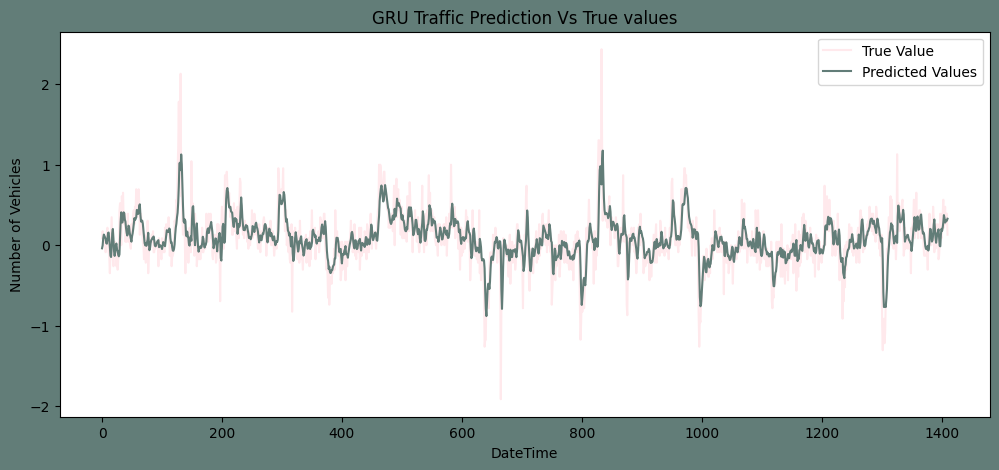

In [ ]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [ ]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.2343

88/88 [==============================] - 9s 15ms/step - loss: 0.2343
Epoch 2/50
84/88 [===========================>..] - ETA: 0s - loss: 0.2054

88/88 [==============================] - 1s 13ms/step - loss: 0.2053
Epoch 3/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1981

88/88 [==============================] - 1s 12ms/step - loss: 0.1982
Epoch 4/50
86/88 [============================>.] - ETA: 0s - loss: 0.1953

88/88 [==============================] - 1s 13ms/step - loss: 0.1951
Epoch 5/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1955

88/88 [==============================] - 1s 13ms/step - loss: 0.1947
Epoch 6/50
86/88 [============================>.] - ETA: 0s - loss: 0.1915

88/88 [==============================] - 1s 13ms/step - loss: 0.1918
Epoch 7/50
87/88 [============================>.] - ETA: 0s - loss: 0.1915

88/88 [==============================] - 1s 13ms/step - loss: 0.1914
Epoch 8/50
87/88 [============================>.] - ETA: 0s - loss: 0.1919

88/88 [==============================] - 1s 13ms/step - loss: 0.1918
Epoch 9/50
86/88 [============================>.] - ETA: 0s - loss: 0.1908

88/88 [==============================] - 1s 13ms/step - loss: 0.1906
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.1905

88/88 [==============================] - 1s 17ms/step - loss: 0.1905
Epoch 11/50
87/88 [============================>.] - ETA: 0s - loss: 0.1886

88/88 [==============================] - 2s 18ms/step - loss: 0.1887
Epoch 12/50
86/88 [============================>.] - ETA: 0s - loss: 0.1886

88/88 [==============================] - 1s 13ms/step - loss: 0.1884
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.1876

88/88 [==============================] - 1s 13ms/step - loss: 0.1876
Epoch 14/50
86/88 [============================>.] - ETA: 0s - loss: 0.1876

88/88 [==============================] - 1s 13ms/step - loss: 0.1874
Epoch 15/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1870

88/88 [==============================] - 1s 13ms/step - loss: 0.1862
Epoch 16/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1879

88/88 [==============================] - 1s 13ms/step - loss: 0.1887
Epoch 17/50
87/88 [============================>.] - ETA: 0s - loss: 0.1859

88/88 [==============================] - 1s 13ms/step - loss: 0.1858
Epoch 18/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1857

88/88 [==============================] - 1s 13ms/step - loss: 0.1859
Epoch 19/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1856

88/88 [==============================] - 1s 13ms/step - loss: 0.1858
Epoch 20/50
87/88 [============================>.] - ETA: 0s - loss: 0.1861

88/88 [==============================] - 1s 14ms/step - loss: 0.1860
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.1864

88/88 [==============================] - 2s 17ms/step - loss: 0.1864
Epoch 22/50
86/88 [============================>.] - ETA: 0s - loss: 0.1835

88/88 [==============================] - 1s 15ms/step - loss: 0.1841
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.1833

88/88 [==============================] - 1s 14ms/step - loss: 0.1833
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.1849

88/88 [==============================] - 1s 14ms/step - loss: 0.1849
Epoch 25/50
88/88 [==============================] - ETA: 0s - loss: 0.1842

88/88 [==============================] - 1s 14ms/step - loss: 0.1842
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.1842

88/88 [==============================] - 1s 14ms/step - loss: 0.1842
Epoch 27/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1842

88/88 [==============================] - 1s 14ms/step - loss: 0.1842
Epoch 28/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1853

88/88 [==============================] - 1s 13ms/step - loss: 0.1842
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.1839

88/88 [==============================] - 1s 14ms/step - loss: 0.1839
Epoch 30/50
87/88 [============================>.] - ETA: 0s - loss: 0.1843

88/88 [==============================] - 1s 16ms/step - loss: 0.1841
Epoch 31/50
88/88 [==============================] - ETA: 0s - loss: 0.1836

88/88 [==============================] - 2s 18ms/step - loss: 0.1836
Epoch 32/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1835

88/88 [==============================] - 1s 13ms/step - loss: 0.1839
Epoch 33/50
86/88 [============================>.] - ETA: 0s - loss: 0.1831

88/88 [==============================] - 1s 13ms/step - loss: 0.1833
Epoch 34/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1822

88/88 [==============================] - 1s 13ms/step - loss: 0.1829
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.1814

88/88 [==============================] - 2s 20ms/step - loss: 0.1814
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.1820

88/88 [==============================] - 1s 14ms/step - loss: 0.1820
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.1822

88/88 [==============================] - 1s 14ms/step - loss: 0.1822
Epoch 38/50
88/88 [==============================] - ETA: 0s - loss: 0.1824

88/88 [==============================] - 1s 14ms/step - loss: 0.1824
Epoch 39/50
88/88 [==============================] - ETA: 0s - loss: 0.1826

88/88 [==============================] - 1s 14ms/step - loss: 0.1826
Epoch 40/50
87/88 [============================>.] - ETA: 0s - loss: 0.1827

88/88 [==============================] - 2s 18ms/step - loss: 0.1826
Epoch 41/50
88/88 [==============================] - ETA: 0s - loss: 0.1821

88/88 [==============================] - 1s 15ms/step - loss: 0.1821
Epoch 42/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1814

88/88 [==============================] - 1s 13ms/step - loss: 0.1813
Epoch 43/50
87/88 [============================>.] - ETA: 0s - loss: 0.1818

88/88 [==============================] - 1s 13ms/step - loss: 0.1816
Epoch 44/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1827

88/88 [==============================] - 1s 13ms/step - loss: 0.1826
Epoch 45/50
87/88 [============================>.] - ETA: 0s - loss: 0.1814

88/88 [==============================] - 1s 13ms/step - loss: 0.1814
Epoch 46/50
86/88 [============================>.] - ETA: 0s - loss: 0.1822

88/88 [==============================] - 1s 13ms/step - loss: 0.1821
Epoch 47/50
86/88 [============================>.] - ETA: 0s - loss: 0.1816

88/88 [==============================] - 1s 13ms/step - loss: 0.1818
Epoch 48/50
87/88 [============================>.] - ETA: 0s - loss: 0.1812

88/88 [==============================] - 1s 13ms/step - loss: 0.1811
Epoch 49/50
87/88 [============================>.] - ETA: 0s - loss: 0.1807

88/88 [==============================] - 2s 19ms/step - loss: 0.1808
Epoch 50/50
86/88 [============================>.] - ETA: 0s - loss: 0.1836

45/45 [==============================] - 2s 6ms/step


The root mean squared error is 0.5546189422436814.


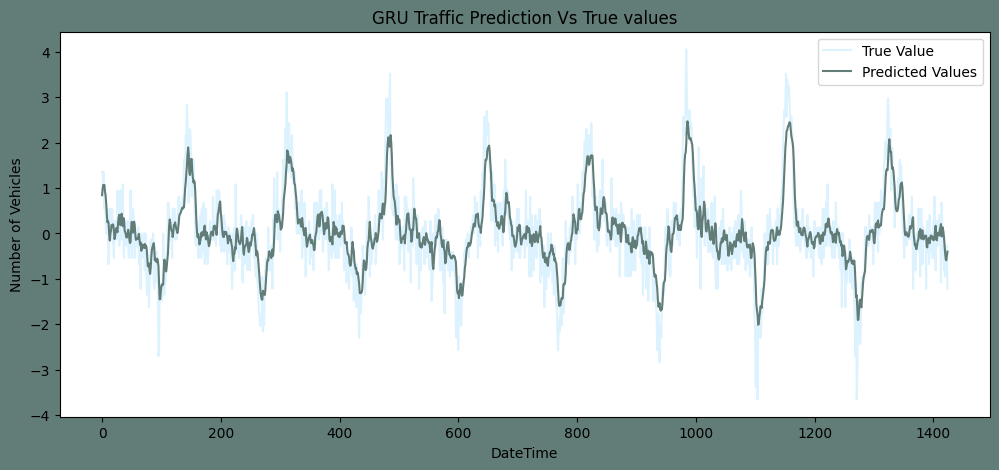

In [ ]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [ ]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2955

88/88 [==============================] - 9s 14ms/step - loss: 0.3026
Epoch 2/50
87/88 [============================>.] - ETA: 0s - loss: 0.2926

88/88 [==============================] - 1s 13ms/step - loss: 0.2928
Epoch 3/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2922

88/88 [==============================] - 1s 13ms/step - loss: 0.2916
Epoch 4/50
87/88 [============================>.] - ETA: 0s - loss: 0.2900

88/88 [==============================] - 1s 13ms/step - loss: 0.2898
Epoch 5/50
86/88 [============================>.] - ETA: 0s - loss: 0.2891

88/88 [==============================] - 1s 15ms/step - loss: 0.2882
Epoch 6/50
87/88 [============================>.] - ETA: 0s - loss: 0.2888

88/88 [==============================] - 1s 16ms/step - loss: 0.2893
Epoch 7/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2854

88/88 [==============================] - 1s 13ms/step - loss: 0.2882
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.2893

88/88 [==============================] - 1s 13ms/step - loss: 0.2893
Epoch 9/50
84/88 [===========================>..] - ETA: 0s - loss: 0.2925

88/88 [==============================] - 1s 13ms/step - loss: 0.2887
Epoch 10/50
86/88 [============================>.] - ETA: 0s - loss: 0.2869

88/88 [==============================] - 1s 13ms/step - loss: 0.2852
Epoch 11/50
84/88 [===========================>..] - ETA: 0s - loss: 0.2860

88/88 [==============================] - 1s 13ms/step - loss: 0.2856
Epoch 12/50
87/88 [============================>.] - ETA: 0s - loss: 0.2851

88/88 [==============================] - 1s 13ms/step - loss: 0.2847
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.2848

88/88 [==============================] - 1s 13ms/step - loss: 0.2848
Epoch 14/50
88/88 [==============================] - ETA: 0s - loss: 0.2840

88/88 [==============================] - 1s 13ms/step - loss: 0.2840
Epoch 15/50
88/88 [==============================] - ETA: 0s - loss: 0.2828

88/88 [==============================] - 1s 13ms/step - loss: 0.2828
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.2844

88/88 [==============================] - 2s 18ms/step - loss: 0.2844
Epoch 17/50
86/88 [============================>.] - ETA: 0s - loss: 0.2814

88/88 [==============================] - 1s 16ms/step - loss: 0.2808
Epoch 18/50
87/88 [============================>.] - ETA: 0s - loss: 0.2796

88/88 [==============================] - 1s 13ms/step - loss: 0.2790
Epoch 19/50
87/88 [============================>.] - ETA: 0s - loss: 0.2828

88/88 [==============================] - 1s 13ms/step - loss: 0.2823
Epoch 20/50
86/88 [============================>.] - ETA: 0s - loss: 0.2790

88/88 [==============================] - 1s 13ms/step - loss: 0.2779
Epoch 21/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2797

88/88 [==============================] - 1s 13ms/step - loss: 0.2777
Epoch 22/50
87/88 [============================>.] - ETA: 0s - loss: 0.2705

88/88 [==============================] - 1s 13ms/step - loss: 0.2751
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.2765

88/88 [==============================] - 1s 13ms/step - loss: 0.2765
Epoch 24/50
86/88 [============================>.] - ETA: 0s - loss: 0.2746

88/88 [==============================] - 1s 13ms/step - loss: 0.2737
Epoch 25/50
86/88 [============================>.] - ETA: 0s - loss: 0.2757

88/88 [==============================] - 1s 14ms/step - loss: 0.2750
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.2793

88/88 [==============================] - 2s 18ms/step - loss: 0.2793
Epoch 27/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2723

88/88 [==============================] - 2s 17ms/step - loss: 0.2762
Epoch 28/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2766

88/88 [==============================] - 1s 14ms/step - loss: 0.2747
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.2743

88/88 [==============================] - 1s 15ms/step - loss: 0.2743
Epoch 30/50
86/88 [============================>.] - ETA: 0s - loss: 0.2659

88/88 [==============================] - 1s 14ms/step - loss: 0.2705
Epoch 31/50
87/88 [============================>.] - ETA: 0s - loss: 0.2764

88/88 [==============================] - 1s 14ms/step - loss: 0.2758
Epoch 32/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2710

88/88 [==============================] - 1s 14ms/step - loss: 0.2742
Epoch 33/50
87/88 [============================>.] - ETA: 0s - loss: 0.2573

88/88 [==============================] - 1s 14ms/step - loss: 0.2704
Epoch 34/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2753

88/88 [==============================] - 1s 14ms/step - loss: 0.2727
Epoch 35/50
87/88 [============================>.] - ETA: 0s - loss: 0.2699

88/88 [==============================] - 1s 16ms/step - loss: 0.2694
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.2699

88/88 [==============================] - 2s 18ms/step - loss: 0.2699
Epoch 37/50
86/88 [============================>.] - ETA: 0s - loss: 0.2666

88/88 [==============================] - 1s 15ms/step - loss: 0.2682
Epoch 38/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2715

88/88 [==============================] - 1s 14ms/step - loss: 0.2712
Epoch 39/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2643

88/88 [==============================] - 1s 14ms/step - loss: 0.2675
Epoch 40/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2733

88/88 [==============================] - 1s 14ms/step - loss: 0.2705
Epoch 41/50
87/88 [============================>.] - ETA: 0s - loss: 0.2691

88/88 [==============================] - 1s 14ms/step - loss: 0.2686
Epoch 42/50
87/88 [============================>.] - ETA: 0s - loss: 0.2673

88/88 [==============================] - 1s 13ms/step - loss: 0.2665
Epoch 43/50
88/88 [==============================] - ETA: 0s - loss: 0.2641

88/88 [==============================] - 1s 13ms/step - loss: 0.2641
Epoch 44/50
88/88 [==============================] - ETA: 0s - loss: 0.2640

88/88 [==============================] - 1s 13ms/step - loss: 0.2640
Epoch 45/50
86/88 [============================>.] - ETA: 0s - loss: 0.2707

88/88 [==============================] - 1s 15ms/step - loss: 0.2704
Epoch 46/50
86/88 [============================>.] - ETA: 0s - loss: 0.2624

88/88 [==============================] - 1s 16ms/step - loss: 0.2641
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.2641

88/88 [==============================] - 1s 14ms/step - loss: 0.2641
Epoch 48/50
86/88 [============================>.] - ETA: 0s - loss: 0.2674

88/88 [==============================] - 1s 13ms/step - loss: 0.2667
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.2627

88/88 [==============================] - 1s 13ms/step - loss: 0.2627
Epoch 50/50
84/88 [===========================>..] - ETA: 0s - loss: 0.2659

45/45 [==============================] - 2s 6ms/step


The root mean squared error is 0.6051958350036339.


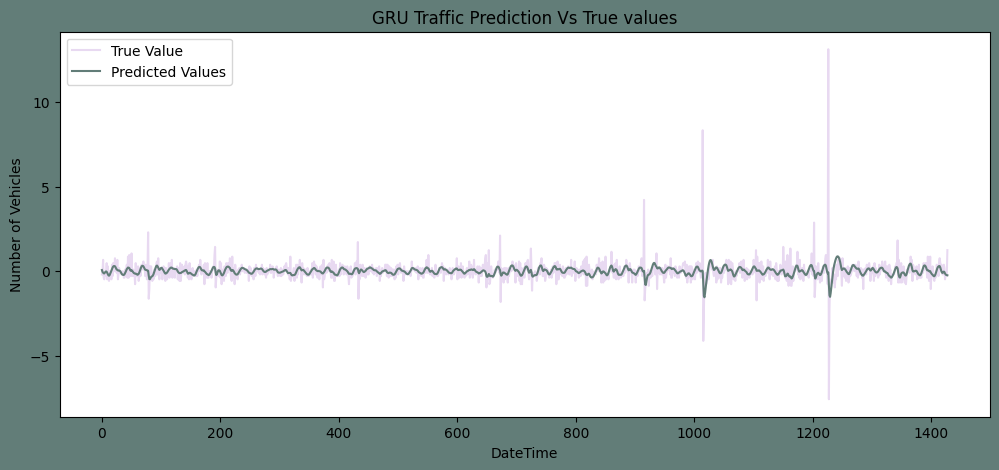

In [ ]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [ ]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.6905

26/26 [==============================] - 9s 19ms/step - loss: 0.6905
Epoch 2/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6872

26/26 [==============================] - 0s 13ms/step - loss: 0.6892
Epoch 3/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6819

26/26 [==============================] - 0s 13ms/step - loss: 0.6884
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.6870

26/26 [==============================] - 0s 13ms/step - loss: 0.6870
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.6849

26/26 [==============================] - 0s 13ms/step - loss: 0.6849
Epoch 6/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6855

26/26 [==============================] - 0s 14ms/step - loss: 0.6861
Epoch 7/50
26/26 [==============================] - ETA: 0s - loss: 0.6821

26/26 [==============================] - 0s 14ms/step - loss: 0.6821
Epoch 8/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6773

26/26 [==============================] - 0s 14ms/step - loss: 0.6807
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.6808

26/26 [==============================] - 0s 13ms/step - loss: 0.6808
Epoch 10/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6904

26/26 [==============================] - 0s 14ms/step - loss: 0.6835
Epoch 11/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6778

26/26 [==============================] - 0s 14ms/step - loss: 0.6798
Epoch 12/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6888

26/26 [==============================] - 0s 13ms/step - loss: 0.6777
Epoch 13/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6641

26/26 [==============================] - 0s 14ms/step - loss: 0.6777
Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.6779

26/26 [==============================] - 0s 13ms/step - loss: 0.6779
Epoch 15/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6775

26/26 [==============================] - 0s 13ms/step - loss: 0.6782
Epoch 16/50
26/26 [==============================] - ETA: 0s - loss: 0.6827

26/26 [==============================] - 0s 13ms/step - loss: 0.6827
Epoch 17/50
22/26 [========================>.....] - ETA: 0s - loss: 0.6914

26/26 [==============================] - 0s 13ms/step - loss: 0.6751
Epoch 18/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6705

26/26 [==============================] - 0s 13ms/step - loss: 0.6766
Epoch 19/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6758

26/26 [==============================] - 0s 13ms/step - loss: 0.6737
Epoch 20/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6738

26/26 [==============================] - 0s 14ms/step - loss: 0.6745
Epoch 21/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6714

26/26 [==============================] - 0s 13ms/step - loss: 0.6704
Epoch 22/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6787

26/26 [==============================] - 0s 13ms/step - loss: 0.6778
Epoch 23/50
26/26 [==============================] - ETA: 0s - loss: 0.6701

26/26 [==============================] - 0s 13ms/step - loss: 0.6701
Epoch 24/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6770

26/26 [==============================] - 0s 13ms/step - loss: 0.6711
Epoch 25/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6643

26/26 [==============================] - 0s 12ms/step - loss: 0.6710
Epoch 26/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6839

26/26 [==============================] - 0s 13ms/step - loss: 0.6825
Epoch 27/50
26/26 [==============================] - ETA: 0s - loss: 0.6873

26/26 [==============================] - 0s 13ms/step - loss: 0.6873
Epoch 28/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6695

26/26 [==============================] - 0s 13ms/step - loss: 0.6714
Epoch 29/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6508

26/26 [==============================] - 0s 18ms/step - loss: 0.6651
Epoch 30/50
26/26 [==============================] - ETA: 0s - loss: 0.6656

26/26 [==============================] - 0s 17ms/step - loss: 0.6656
Epoch 31/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6683

26/26 [==============================] - 0s 17ms/step - loss: 0.6673
Epoch 32/50
26/26 [==============================] - ETA: 0s - loss: 0.6595

26/26 [==============================] - 0s 17ms/step - loss: 0.6595
Epoch 33/50
26/26 [==============================] - ETA: 0s - loss: 0.6552

26/26 [==============================] - 0s 17ms/step - loss: 0.6552
Epoch 34/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6523

26/26 [==============================] - 0s 17ms/step - loss: 0.6523
Epoch 35/50
22/26 [========================>.....] - ETA: 0s - loss: 0.6374

26/26 [==============================] - 0s 13ms/step - loss: 0.6504
Epoch 36/50
26/26 [==============================] - ETA: 0s - loss: 0.6414

26/26 [==============================] - 0s 13ms/step - loss: 0.6414
Epoch 37/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6346

26/26 [==============================] - 0s 13ms/step - loss: 0.6333
Epoch 38/50
26/26 [==============================] - ETA: 0s - loss: 0.6290

26/26 [==============================] - 0s 13ms/step - loss: 0.6290
Epoch 39/50
26/26 [==============================] - ETA: 0s - loss: 0.6212

26/26 [==============================] - 0s 13ms/step - loss: 0.6212
Epoch 40/50
26/26 [==============================] - ETA: 0s - loss: 0.6096

26/26 [==============================] - 0s 13ms/step - loss: 0.6096
Epoch 41/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6054

26/26 [==============================] - 0s 13ms/step - loss: 0.6010
Epoch 42/50
23/26 [=========================>....] - ETA: 0s - loss: 0.5733

26/26 [==============================] - 0s 13ms/step - loss: 0.5930
Epoch 43/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6066

26/26 [==============================] - 0s 13ms/step - loss: 0.6043
Epoch 44/50
25/26 [===========================>..] - ETA: 0s - loss: 0.5863

26/26 [==============================] - 0s 14ms/step - loss: 0.5828
Epoch 45/50
26/26 [==============================] - ETA: 0s - loss: 0.5725

26/26 [==============================] - 0s 13ms/step - loss: 0.5725
Epoch 46/50
26/26 [==============================] - ETA: 0s - loss: 0.5687

26/26 [==============================] - 0s 14ms/step - loss: 0.5687
Epoch 47/50
25/26 [===========================>..] - ETA: 0s - loss: 0.5552

26/26 [==============================] - 0s 13ms/step - loss: 0.5566
Epoch 48/50
25/26 [===========================>..] - ETA: 0s - loss: 0.5607

26/26 [==============================] - 0s 13ms/step - loss: 0.5605
Epoch 49/50
25/26 [===========================>..] - ETA: 0s - loss: 0.5578

26/26 [==============================] - 0s 14ms/step - loss: 0.5602
Epoch 50/50
25/26 [===========================>..] - ETA: 0s - loss: 0.5478

13/13 [==============================] - 1s 6ms/step


The root mean squared error is 1.0113799394182825.


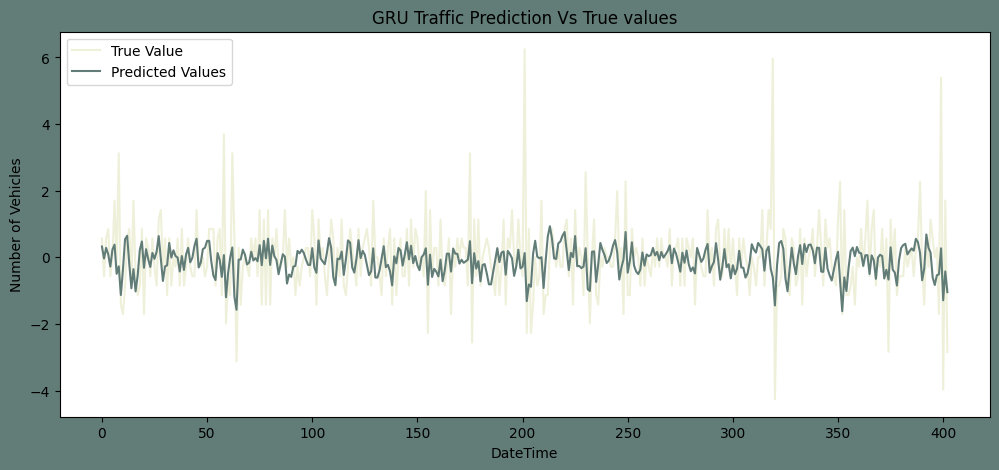

In [ ]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [ ]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

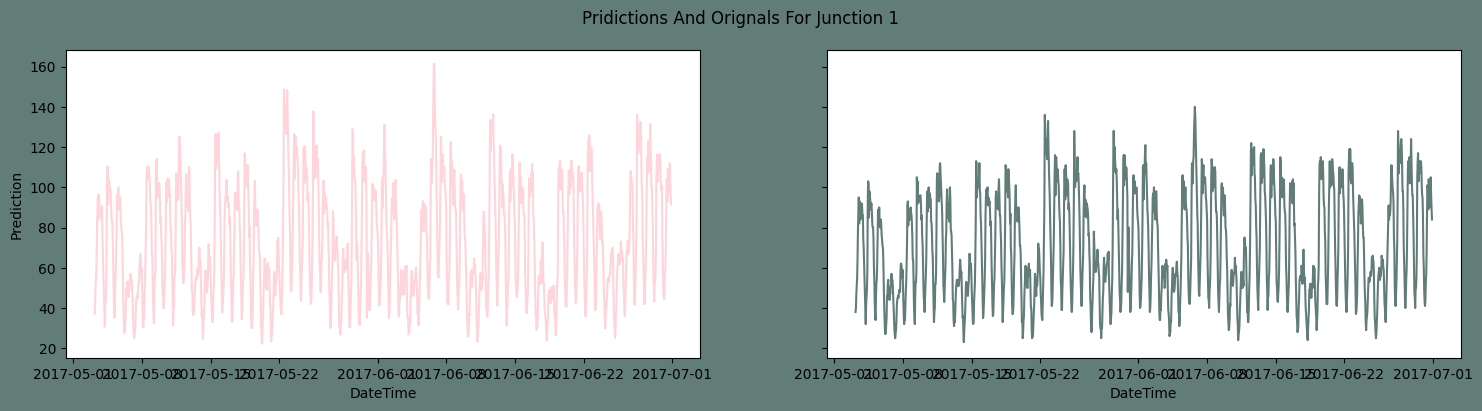

In [ ]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)


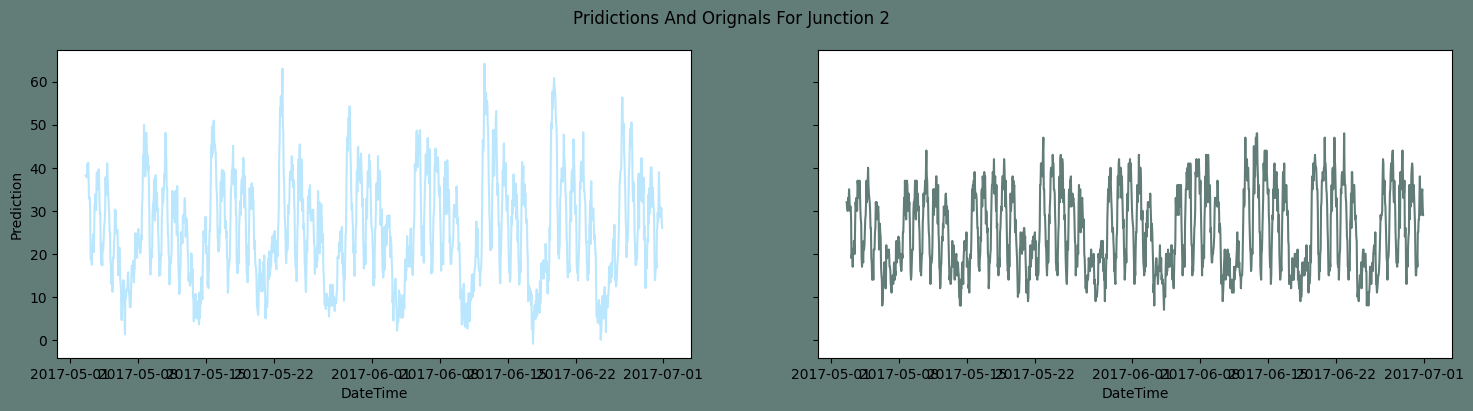

In [ ]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

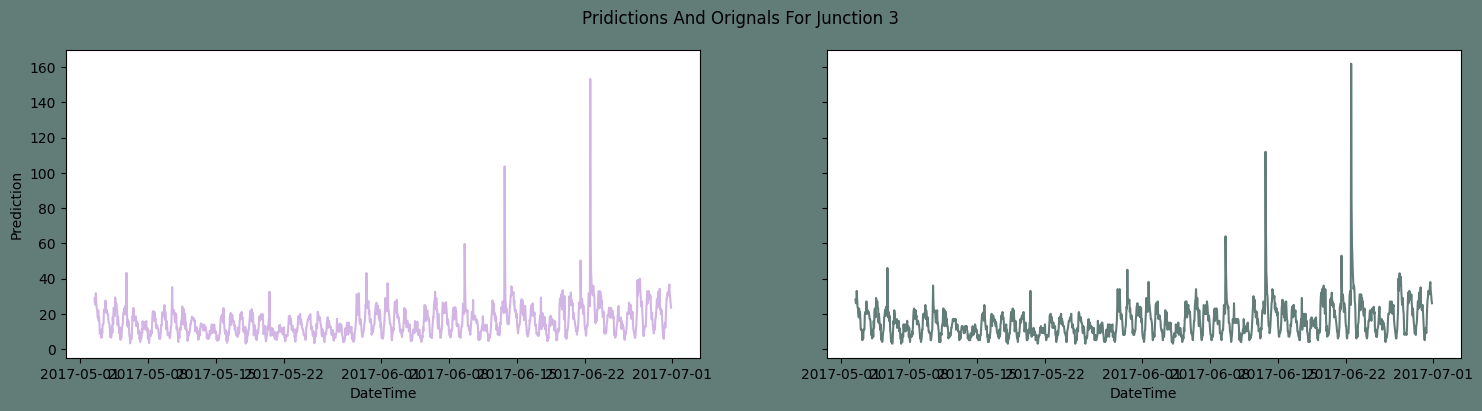

In [ ]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

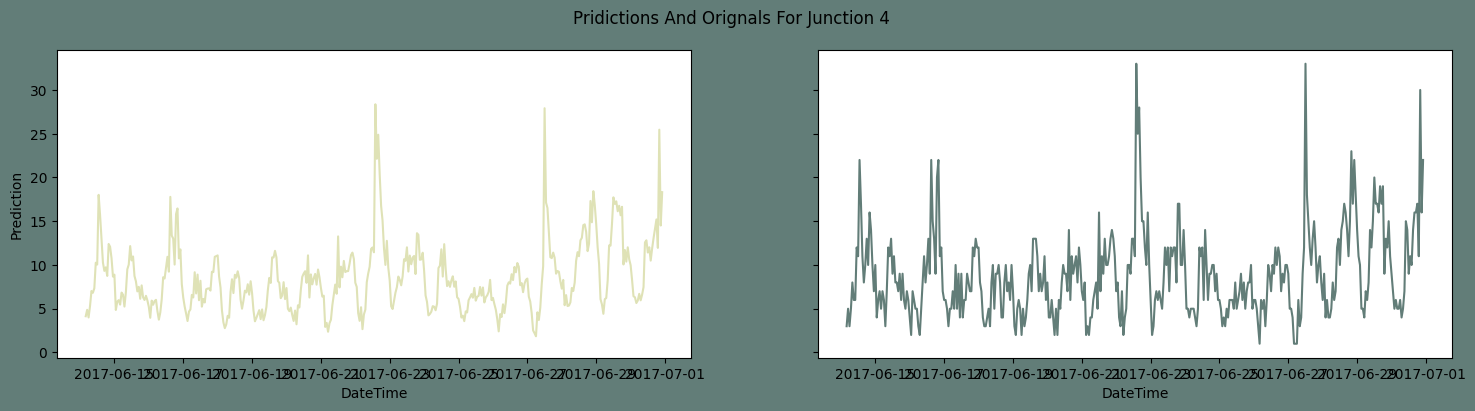

In [ ]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)